# ***F1 Racing Data Analysis***
**Jeffrey Glupker, Penn Murfee, Benjamin Richman**<br>
**March 20, 2018**

In [1]:
#Print all outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
import pydotplus as pyd
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.linear_model import LogisticRegression

pd.options.display.max_columns=999
%matplotlib inline

## Import  Data

In [3]:
df = pd.read_csv('results.csv')
status = pd.read_csv('status.csv')
races = pd.read_csv('races.csv')
circuits = pd.read_csv('circuits.csv')
constructors = pd.read_csv('constructors.csv')
drivers = pd.read_csv('drivers.csv')
qualifying = pd.read_csv('qualifying.csv')

## Merge Data - Base Dataframe

In [4]:
df = df.merge(status, left_on='statusId',right_on='statusId',how='left')
df = df.merge(races, left_on='raceId',right_on='raceId',how='left')
df = df.merge(circuits, left_on='circuitId',right_on='circuitId',how='left')
df = df.merge(constructors, left_on='constructorId',right_on='constructorId',how='left')
df = df.merge(drivers, left_on='driverId',right_on='driverId',how='left')
df = df.merge(qualifying, left_on=['raceId','driverId','constructorId','number_x'],
              right_on=['raceId','driverId','constructorId','number'],how='left')

## Edit Dataframe (please see column metadata at the end of this section)

In [5]:
df.drop(['resultId','statusId','time_y','url_x','name_y','lat','lng','url_y','position_x','fastestLapTime','fastestLapSpeed',
        'circuitRef','alt','url_x','Unnamed: 5','code','forename',
        'surname','number_x','location','name_x','number_y','time_x','milliseconds','rank','positionText',
        'fastestLap','circuitId','q1','q2','q3','qualifyId','number'],axis=1,inplace=True)

In [6]:
df.rename(columns = {'points':'racepoints','nationality_x':'constructorNationality','laps':'lapsfinished',
                    'nationality_y':'driverNationality','position_y':'qualifyingposition','name':'constructorName'},
          inplace = True)

In [7]:
df.country.replace(to_replace=['Australia', 'Malaysia'], value=['Australian','Malaysian'],inplace=True)

df.country.replace(to_replace=['Spain','Turkey','Monaco','Canada','France','UK','Germany','Hungary','Belgium',
                               'Italy','Japan','Brazil','USA','Austria','Argentina','Portugal','South Africa','Mexico',
                               'Netherlands','Sweden','Switzerland','India','Russia'], 
                   value=['Spanish','Turkish','Monegasque','Canadian','French','British','German','Hungarian',
                          'Belgian','Italian','Japanese','Brazilian','American','Austrian','Argentine','Portuguese',
                          'South African','Mexican','Dutch','Swedish','Swiss','Indian','Russian'],inplace=True)



In [8]:
df['drivercountrymatch'] = (df.country == df.driverNationality)*1.0

df['constcountrymatch'] = (df.country == df.constructorNationality)*1.0

In [9]:
df.country = df.country.str.lower()

df['region'] = df.country.replace({'australian':'australia_nz'})

df['region'] = df.region.replace(to_replace=['spanish','french','british','german','hungarian','belgian',
                                              'italian','austrian','portugeuese','dutch','swiss','swedish','monegasque'],
                                              value='europe')

df['region'] = df.region.replace(to_replace=['malaysian','singapore','japanese','china','korea','indian','russian'],
                                 value='asia')

df['region'] = df.region.replace(to_replace=['bahrain','turkish','azerbaijan'],value='middle_east')

df['region'] = df.region.replace(to_replace=['canadian','american','argentine','brazilian','mexican'],value='americas')

df['region'] = df.region.replace(to_replace=['south african','uae','morocco'],value='africa')

df.drop('country', axis = 1, inplace=True)

In [10]:
df.constructorNationality = df.constructorNationality.str.lower()

df['constructorRegion'] = df.constructorNationality.replace(to_replace=['australian','new zealand'],value='australia_nz')

df['constructorRegion'] = df.constructorRegion.replace(to_replace=['irish','french','british','german','hungarian','belgian',
                                              'italian','austrian','dutch','swiss','belgium','east german'],value='europe')

df['constructorRegion'] = df.constructorRegion.replace(to_replace=['canadian','american','brazilian','mexican'],value='americas')

df['constructorRegion'] = df.constructorRegion.replace(to_replace=['malaysian','japanese','indian','russian'],value='asia')

df.drop('constructorNationality', axis = 1, inplace=True)

In [11]:
df.driverNationality = df.driverNationality.str.lower()

df['driverRegion'] = df.driverNationality.replace(to_replace=['australian','new zealander'],value='australia_nz')

df['driverRegion'] = df.driverRegion.replace(to_replace=['german','spanish','finnish','french','polish','british',
                                                        'italian','austrian','dutch','portuguese','hungarian',
                                                        'irish','danish','czech','belgian','swiss',
                                                        'monegasque','swedish','liechtensteiner','east german'],value='europe')

df['driverRegion'] = df.driverRegion.replace(to_replace=['japanese','indian','malaysian','thai','indonesian'],value='asia')

df['driverRegion'] = df.driverRegion.replace(to_replace=['brazilian','american','colombian','canadian','argentine',
                                                        'venezuelan','chilean','mexican','american-italian','argentine-italian',
                                                         'uruguayan'],value='americas')

df['driverRegion'] = df.driverRegion.replace(to_replace=['south african','rhodesian'],value='africa')

df.drop('driverNationality', axis = 1, inplace=True)

In [12]:
df['birthyear'] = df.dob.str[6:]

df.drop('dob', axis=1, inplace=True)

df.year = pd.to_numeric(df.year, errors = 'coerce')

df.birthyear = pd.to_numeric(df.birthyear, errors = 'coerce')

df['driverage'] = (df.year - df.birthyear)*1.0

df.drop('date', axis=1, inplace=True)

In [13]:
dflaps = df.iloc[:,:7]

finishlaps = dflaps.groupby('raceId', as_index = False).agg({'lapsfinished':'max'}).rename(columns = {'lapsfinished':'laps'})

df = df.merge(finishlaps, left_on = 'raceId', right_on = 'raceId')

df['lapsfinishedpct'] = (df.lapsfinished/df.laps)*1.0

In [14]:
df['wins'] = (df.positionOrder == 1)*1.0

In [15]:
df['top10'] = (df.racepoints > 0)*1.0

**Lap and pitstop data**

In [16]:
laptimes = pd.read_csv('laptimes.csv')
pitstops = pd.read_csv('pitStops.csv')

Merge data

In [17]:
laps = laptimes.merge(pitstops, how='left', left_on=['raceId', 'driverId', 'lap'],
                        right_on=['raceId', 'driverId', 'lap'])

Change column names

In [18]:
colnames = [u'raceId', u'driverId', u'lap', u'currentposition', u'laptime',
       u'lapmilliseconds', u'stop', u'stoptime', u'stopduration', u'stopmilliseconds']
laps.columns = colnames

In [19]:
laps.drop(['stoptime', 'stopduration', 'laptime'], axis=1, inplace=True)

In [20]:
laps['pitstop'] = (laps.stop > 0)*1.0
laps.drop('stop', axis=1, inplace=True)

In [21]:
laps['lapduration'] = laps.lapmilliseconds/1000.0
laps['pitstopduration'] = laps.stopmilliseconds/1000.0

In [22]:
laps.drop(['lapmilliseconds','stopmilliseconds'], axis=1, inplace=True)

In [23]:
pitlapdur = laps.groupby(['raceId','driverId'], sort=False, as_index=False).agg({'lapduration':'mean','pitstop':'sum'})

We only want the pitstop rows, since when they don't stop their duration is 0 and that skews the average

In [24]:
pitstops = laps[laps.pitstopduration>0]

In [25]:
pitduration = pitstops.groupby(['raceId','driverId'], sort=False, as_index=False).agg({'pitstopduration':'mean'})

Merge onto original dataframe

In [26]:
df = df.merge(pitduration, how='left', left_on=['raceId', 'driverId'],
                        right_on=['raceId', 'driverId'])

In [27]:
df = df.merge(pitlapdur, how='left', left_on=['raceId', 'driverId'],
                        right_on=['raceId', 'driverId'])

In [28]:
df.pitstopduration.fillna(0.0, inplace=True)

In [29]:
lapsfirst = laps[laps.currentposition == 1]

lapsinfirst = lapsfirst.groupby(['raceId', 'driverId'], sort=False, as_index=False).agg(
                                {'currentposition':'sum'}).rename(columns={'currentposition':'lapsinfirst'})

In [30]:
lapstopthree = laps[laps.currentposition <= 3]

lapstopthree['top3'] = 1.0

lapsthree = lapstopthree.groupby(['raceId', 'driverId'], sort=False, as_index=False).agg(
                                {'top3':'sum'}).rename(columns={'top3':'lapstop3'})

C:\Users\Jeff Glupker\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [31]:
lapstopfive = laps[laps.currentposition <= 5]

lapstopfive['top5'] = 1.0

lapsfive = lapstopfive.groupby(['raceId', 'driverId'],sort=False, as_index=False).agg(
                                {'top5':'sum'}).rename(columns={'top5':'lapstop5'})

C:\Users\Jeff Glupker\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [32]:
lapstopten = laps[laps.currentposition <= 10]

lapstopten['top10'] = 1.0

lapsten = lapstopten.groupby(['raceId', 'driverId'], sort=False, as_index=False).agg(
                            {'top10':'sum'}).rename(columns={'top10':'lapstop10'}).rename(columns={'top5':'lapstop5'})

C:\Users\Jeff Glupker\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [33]:
lapsinfirst['lapsleading'] = lapsinfirst.lapsinfirst*1.0

lapsinfirst.drop('lapsinfirst', axis=1, inplace=True)

Merge onto base dataframe

In [34]:
df = df.merge(lapsinfirst, how='left', left_on=['raceId', 'driverId'],
                        right_on=['raceId', 'driverId'])

df = df.merge(lapsthree, how='left', left_on=['raceId', 'driverId'],
                        right_on=['raceId', 'driverId'])

df = df.merge(lapsfive, how='left', left_on=['raceId', 'driverId'],
                        right_on=['raceId', 'driverId'])

df = df.merge(lapsten, how='left', left_on=['raceId', 'driverId'],
                        right_on=['raceId', 'driverId'])

In [35]:
df.lapsleading.fillna(0.0, inplace=True)

df.lapstop3.fillna(0.0, inplace=True)

df.lapstop5.fillna(0.0, inplace=True)

df.lapstop10.fillna(0.0, inplace=True)

df.qualifyingposition.fillna(29.0, inplace=True)

df.pitstop.fillna(0.0, inplace=True)

In [36]:
df['lapsleadingpct'] = (df.lapsleading / df.laps)*1.0

In [37]:
df['lapstop3pct'] = (df.lapstop3 / df.laps)*1.0

df['lapstop5pct'] = (df.lapstop5 / df.laps)*1.0

df['lapstop10pct'] = (df.lapstop10 / df.laps)*1.0

In [38]:
df.lapsleadingpct.fillna(0.0, inplace=True)

df.lapstop3pct.fillna(0.0, inplace=True)

df.lapstop5pct.fillna(0.0, inplace=True)

df.lapstop10pct.fillna(0.0, inplace=True)

In [39]:
df.drop(['lapstop3','lapstop5','lapstop10', 'lapduration'], axis = 1, inplace=True)

Add lap position after 10%, 25%, 50% of the race

In [40]:
laps2 = df.groupby('raceId', as_index=False).agg({'laps':'max'})

In [41]:
laps2['10pct'] = (laps2.laps*0.10).round(decimals=0)

laps2['25pct'] = (laps2.laps*0.25).round(decimals=0)

laps2['50pct'] = (laps2.laps*0.50).round(decimals=0)

In [42]:
laps = laps.merge(laps2, left_on = 'raceId', right_on= 'raceId', how = 'left')

In [43]:
laps10pct = laps[laps.lap == laps['10pct']]

laps10pct.drop(['laps', '10pct', '25pct', '50pct','lap','pitstop','lapduration','pitstopduration'], axis=1, inplace=True)

laps10pct.rename(columns = {'currentposition':'10pctplace'}, inplace=True)

C:\Users\Jeff Glupker\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Jeff Glupker\AppData\Local\Enthought\Canopy\User\lib\site-packages\pandas\core\frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [44]:
laps25pct = laps[laps.lap == laps['25pct']]

laps25pct.drop(['laps', '10pct', '25pct', '50pct','lap','pitstop','lapduration','pitstopduration'], axis=1, inplace=True)

laps25pct.rename(columns = {'currentposition':'25pctplace'}, inplace=True)

C:\Users\Jeff Glupker\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [45]:
laps50pct = laps[laps.lap == laps['50pct']]

laps50pct.drop(['laps', '10pct', '25pct', '50pct','lap','pitstop','lapduration','pitstopduration'], axis=1, inplace=True)

laps50pct.rename(columns = {'currentposition':'50pctplace'},inplace=True)

C:\Users\Jeff Glupker\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [46]:
df = df.merge(laps10pct, how='left', left_on=['raceId', 'driverId'], right_on=['raceId', 'driverId'])

df = df.merge(laps25pct, how='left', left_on=['raceId', 'driverId'], right_on=['raceId', 'driverId'])

df = df.merge(laps50pct, how='left', left_on=['raceId', 'driverId'], right_on=['raceId', 'driverId'])

In [47]:
df['10pctpos'] = (df.grid - df['10pctplace'])*1.0

df['25pctpos'] = (df.grid - df['25pctplace'])*1.0

df['50pctpos'] = (df.grid - df['50pctplace'])*1.0

df.drop(['10pctplace','25pctplace','50pctplace'], axis=1, inplace=True)

In [48]:
maxgrid = df.groupby('raceId', as_index=False).agg({'grid':'max'})

maxgrid.columns = ['raceId', 'maxgrid']

df = df.merge(maxgrid, how='left', left_on='raceId', right_on='raceId')

In [49]:
df['10pctpos'].fillna(df.grid-df.maxgrid, inplace=True)

df['25pctpos'].fillna(df.grid-df.maxgrid, inplace=True)

df['50pctpos'].fillna(df.grid-df.maxgrid, inplace=True)

df.drop('maxgrid',axis=1,inplace=True)

In [50]:
df['StatusNew'] = df.status.replace(to_replace= ['+1 Lap', 'Disqualified', '+2 Laps', '+4 Laps', '+3 Laps', 'Retired', 
                                                 '+11 Laps', '+5 Laps', '+17 Laps', 'Withdrew', '+12 Laps', '+7 Laps', 
                                                 '+26 Laps', '+6 Laps', '+8 Laps', '107% Rule', 'Did not qualify', 
                                                 'Not restarted', 'Did not prequalify', 'Excluded', '+9 Laps', '+10 Laps', 
                                                 '+14 Laps',  '+15 Laps', '+25 Laps','+18 Laps', '+22 Laps', '+16 Laps', 
                                                 '+24 Laps', '+29 Laps', '+23 Laps', '+21 Laps', '+30 Laps','+44 Laps', 
                                                 '+13 Laps', '+19 Laps', '+46 Laps', '+20 Laps', '+42 Laps', 'Not classified'], 
                                                 value = 'no_finish')

df['StatusNew'] = df.StatusNew.replace(to_replace = ['Finished'], value = 'no_error')

df['StatusNew'] = df.StatusNew.replace(to_replace = ['Engine', 'Transmission', 'Clutch', 'Hydraulics', 'Gearbox', 
                                                     'Radiator', 'Suspension', 'Brakes', 'Overheating', 'Mechanical', 
                                                     'Tyre', 'Driver Seat', 'Driveshaft', 'Fuel pressure', 'Front wing', 
                                                     'Water pressure', 'Refueling', 'Wheel', 'Throttle', 'Steering', 
                                                     'Broken wing', 'Exhaust', 'Oil leak', 'Wheel rim', 'Water leak', 
                                                     'Fuel pump', 'Track rod', 'Oil pressure', 'Pneumatics', 'Engine fire', 
                                                     'Wheel nut', 'Handling', 'Rear wing', 'Fuel system', 'Oil line', 
                                                     'Fuel rig', 'Launch control', 'Drivetrain', 'Ignition', 'Chassis', 
                                                     'Halfshaft', 'Crankshaft', 'Differential', 'Wheel bearing', 'Physical', 
                                                     'Vibrations', 'Safety belt', 'Oil pump', 'Fuel leak', 'Injection', 
                                                     'Distributor', 'Turbo', 'CV joint', 'Water pump', 'Fuel pipe', 
                                                     'Oil pipe', 'Axle', 'Water pipe', 'Supercharger', 'Engine misfire', 
                                                     'ERS', 'Brake duct', 'Seat'], value = 'mechanical_error')

df['StatusNew'] = df.StatusNew.replace(to_replace = ['Collision', 'Accident', 'Spun off', 'Puncture', 'Technical', 
                                                     'Tyre puncture', 'Out of fuel', 'Injured', 'Fuel', 'Safety', 'Injury', 
                                                     'Stalled', 'Safety concerns', 'Underweight', 'Driver unwell', 
                                                     'Fatal accident', 'Eye injury', 'Collision damage', 'Refuelling'], 
                                                    value = 'human_error')

df['StatusNew'] = df.StatusNew.replace(to_replace = ['Electrical', 'Electronics', 'Heat shield fire', 'Fire', 'Power loss', 
                                                     'Battery', 'Alternator','Spark plugs', 'Magneto', 'Power Unit'], 
                                                     value = 'electrical_error')

df.drop('status', axis=1, inplace=True)

Check base dataframe for null values

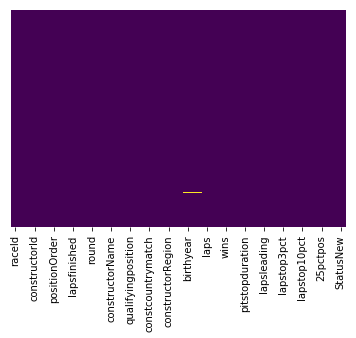

In [51]:
sns.heatmap(df.isnull(),yticklabels=False, cbar=False, cmap='viridis')

In [52]:
len(df)

23777

Drop remaining null values

In [53]:
df.dropna(inplace=True)

In [54]:
len(df)

23734

In [55]:
df.head(3)

,raceId,driverId,constructorId,grid,positionOrder,racepoints,lapsfinished,year,round,constructorRef,constructorName,driverRef,qualifyingposition,drivercountrymatch,constcountrymatch,region,constructorRegion,driverRegion,birthyear,driverage,laps,lapsfinishedpct,wins,top10,pitstopduration,pitstop,lapsleading,lapsleadingpct,lapstop3pct,lapstop5pct,lapstop10pct,10pctpos,25pctpos,50pctpos,StatusNew
0,18,1,1,1,1,10.0,58,2008,1,mclaren,McLaren,hamilton,1.0,0.0,0.0,australia_nz,europe,europe,1985.0,23.0,58,1.0,1.0,1.0,0.0,0.0,50.0,0.862069,0.948276,1.000000,1.0,0.0,0.0,0.0,no_error
1,18,2,2,5,2,8.0,58,2008,1,bmw_sauber,BMW Sauber,heidfeld,5.0,0.0,0.0,australia_nz,europe,europe,1977.0,31.0,58,1.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.517241,0.982759,1.0,0.0,0.0,1.0,no_error
2,18,3,3,7,3,6.0,58,2008,1,williams,Williams,rosberg,7.0,0.0,0.0,australia_nz,europe,europe,1985.0,23.0,58,1.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.258621,0.879310,1.0,3.0,3.0,2.0,no_error


#### Column Metadata

raceId - ID's for each race <br>
driverId - Unique ID number for each driver <br>
constructorId - Unique ID for each constructor/team <br>
grid - Starting position for each driver for each race <br>
positionOrder - Finishing position of a driver for each race<br>
racepoints - Points won for a driver for each race (points awarded to top 10 finishers <br>
lapsfinished - Number of laps finished in a race for each driver <br>
year - Year in which a race happened <br>
round - race number in the season long series <br>
counstructorRef/constructorName - constructor/team name <br>
driverRef - driver name <br>
qualifyingposition - Qualifying position for a driver for each race <br>
drivercoutrymatch - Binary for whether a race was held in a driver's home country <br>
constcountrymatch - Binary for whether a race was held in a constructor's home country <br>
region - Region where a race was held <br>
constructorRegion - Region where a constructor is from <br>
driverRegion - Region where a driver is from <br>
birthyear - Year a driver was born <br>
driverage - Age of driver at time of race <br>
laps - Total laps a race requires to finish <br>
lapsfinishedpct - Percentage of laps finished <br>
wins - Binary for whether a driver won a single race <br>
top10 - Binary for whether a driver finished in the top ten for a race <br>
pitstopduration - Duration of a pitstop <br>
pitstop - Number of pitstops a driver took during a race <br>
lapsleading - Number of laps a driver led during a race <br>
lapsleadingpct - Percentage of laps a driver led during a race <br>
lapstop3pct - Percentage of laps a driver was in the top 3 of a race <br>
lapstop5pct - Percentage of laps a driver was in the top 5 of a race <br>
lapstop10pct - Percentage of laps a driver was in the top 10 of a race <br>
10pctpos - Position of a driver 10 percent of the way through a race <br>
25pctpos - Position of a driver 25 percent of the way through a race <br>
50pctpos - Position of a driver 50 percent of the way through a race <br>
StatusNew - Describes whether a driver finished the race and if they didn't, what caused them not to finish

## Data Visuals

Number of total wins by age of drivers.

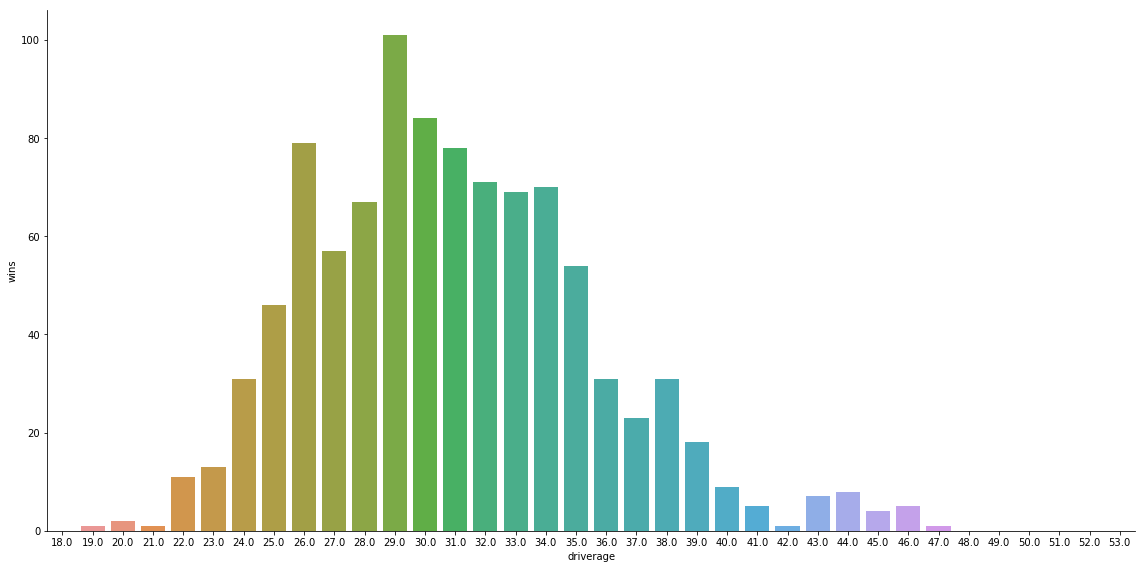

In [56]:
agewins = df.groupby('driverage', as_index=False).agg({'wins':'sum'})
sns.factorplot(x='driverage', y='wins', data=agewins, size=8, aspect=2, kind='bar')

## Data Analysis

### Question 1: Can we predict who will finish in the Top 10 for each race? Note that the Top 10 finishers in a given race all receive points toward the season-long standings.

First, check to see how many instances of drivers finishing in the top 10

In [57]:
df.top10.mean()

0.28107356534928796

In [58]:
top10_set = df.loc[:, ['raceId', 'year','driverId', 'constructorId', 'pitstopduration', 'pitstop', 'top10', 'driverage',
                         'constructorRegion', 'driverRegion']]

In [59]:
top10_set = pd.get_dummies(top10_set, columns = ['driverId', 'constructorId', 'constructorRegion', 'driverRegion'])

Create subset for pitstop-era

In [60]:
top10_subset = top10_set[top10_set.year > 2010]

In [61]:
X10 = top10_subset.drop(['top10', 'pitstopduration'],axis=1)
Y10 = top10_subset.top10
dt = tree.DecisionTreeClassifier(max_depth=2)
dt.fit(X10,Y10)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

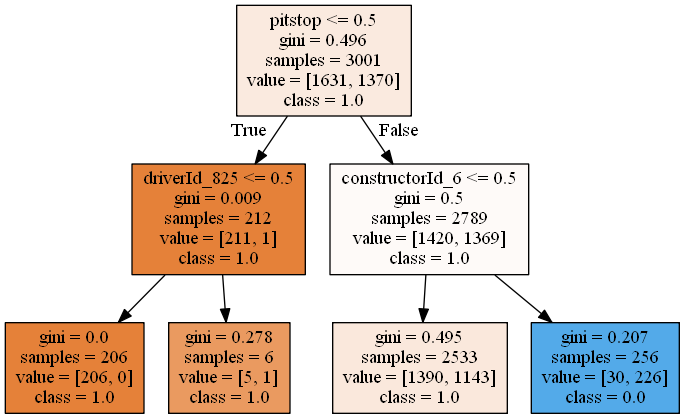

In [62]:
dt_feature_names = list(X10.columns)
dt_target_names = np.array(Y10.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pyd.graph_from_dot_file('tree.dot')
Image(graph.create_png())

**Conclusion: Whether a driver had to make a pit stop or not is the clearest indicator in determining if they will finish the race in the Top 10. This would suggest that a driver should and will only pit if they absolutely have to, likely a result of a problem with the vehicle.**

Show the number of pitstops by year since 2001 (There are no pitstops before 2011).

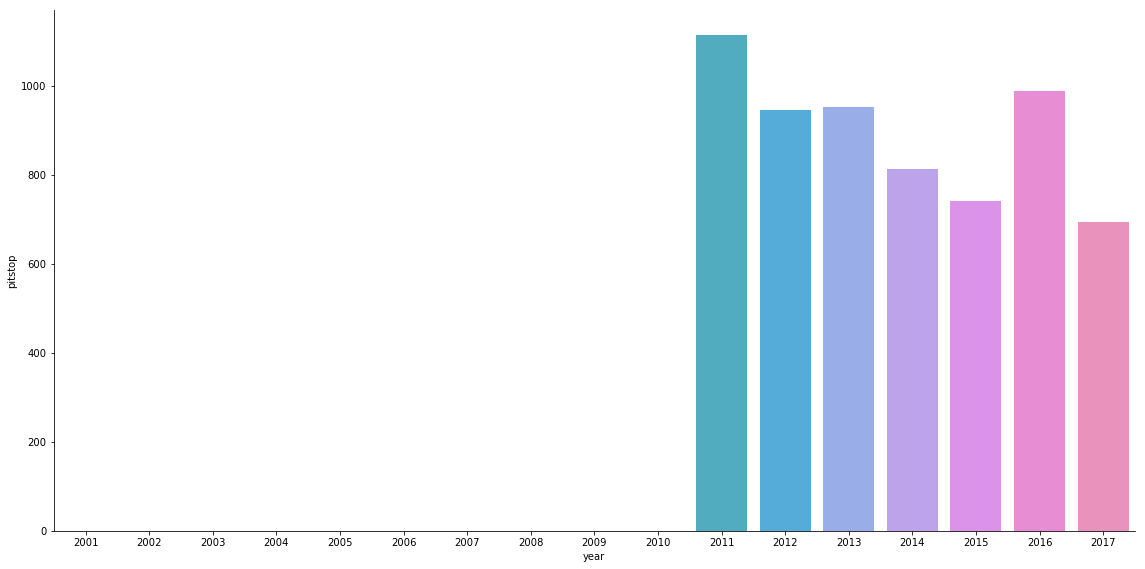

In [63]:
pitbyyear = df.groupby('year',as_index=False).agg({'pitstop':'sum','pitstopduration':'mean'})
sns.factorplot(x='year', y='pitstop', data=pitbyyear[pitbyyear.year > 2000], size=8, aspect=2, kind='bar',)

### Question 2: Can we predict how many points a driver will earn over an entire season?

**Because we only have pit stop data for the most recent years, we will need to split the data into races that occured from 1950 to 2010, and then into races that occured from 2011 to 2017. Comparing the results of the two models will also give us insight into how important having pit stop data is in predicting the final outcome.**

In [64]:
statusdummydf = pd.get_dummies(df, columns=['StatusNew'])

In [65]:
driverdummy = statusdummydf.groupby(['year', 'driverId'],as_index=False).agg(
    {'racepoints':'sum','qualifyingposition':'mean','pitstopduration':'mean',
                                     'pitstop':'mean','lapsleadingpct':'mean','lapstop3pct':'mean','lapstop5pct':'mean',
                                     'lapstop10pct':'mean','wins':'sum','grid':'mean',
                                     'lapsfinishedpct':'mean','top10':'sum','StatusNew_mechanical_error':'sum',
                                                'StatusNew_human_error':'sum','StatusNew_no_error':'sum',
                                                'StatusNew_no_finish':'sum','StatusNew_electrical_error':'sum',
                                                              '10pctpos':'mean','25pctpos':'mean','50pctpos':'mean'})

Shows the number of reasons for not finishing a race over the years.

C:\Users\Jeff Glupker\AppData\Local\Enthought\Canopy\User\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


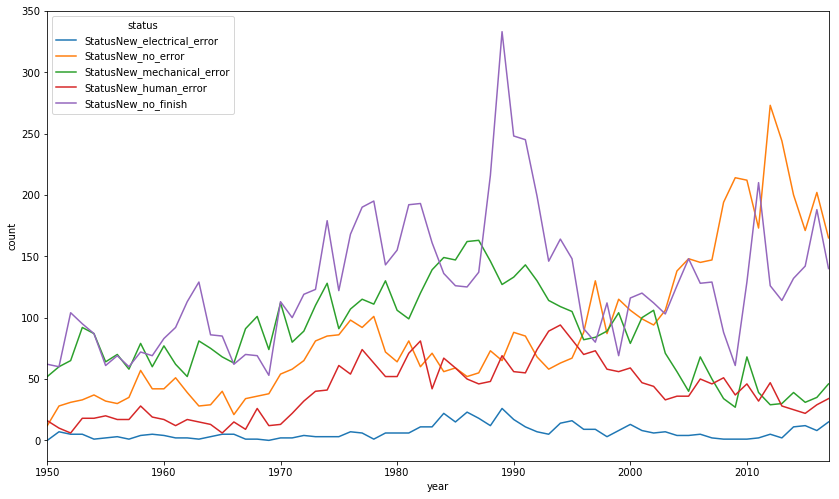

In [66]:
statusbyyear = driverdummy.groupby('year', as_index=False).agg({'StatusNew_no_finish':'sum','StatusNew_electrical_error':'sum',
                                'StatusNew_mechanical_error':'sum','StatusNew_human_error':'sum',
                                'StatusNew_no_error':'sum'})
meltedstatus = pd.melt(statusbyyear, id_vars='year', var_name='status', value_name='count')
meltedstatus['Dummy'] = 0
ax_dims = (14, 8.27)
f, ax = plt.subplots(figsize=ax_dims)
sns.tsplot(meltedstatus, time='year', unit='Dummy', condition='status', value='count', ax=ax)

Split Dataset (First model is based on older data from 1950-2010)

In [67]:
driverseasonold = driverdummy[driverdummy.year <= 2010]

In [68]:
driverseasonnew = driverdummy[driverdummy.year >= 2011]

**First Model**

Set the independent and dependent variables

In [69]:
X2 = driverseasonold.drop('racepoints', axis=1)
y2 = driverseasonold['racepoints']

Split into training and testing data

In [70]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=0)

In [71]:
lm = LinearRegression()

Fit model

In [72]:
lm.fit(X2_train, y2_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Get predicted values

In [73]:
lmpredictions = lm.predict(X2_test)

Graph plots of the predicted vs actual values and the distribution

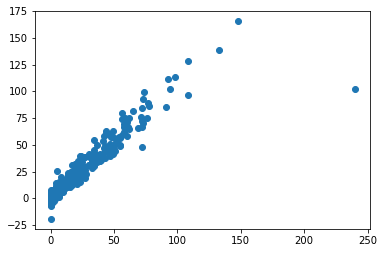

In [74]:
plt.scatter(y2_test, lmpredictions)

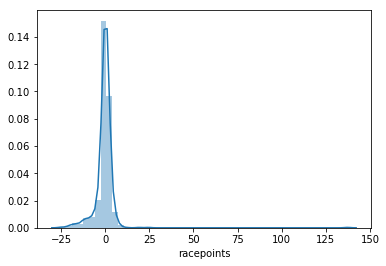

In [75]:
sns.distplot((y2_test - lmpredictions))

Calculate accuracy

In [76]:
sk.metrics.mean_absolute_error(y2_test, lmpredictions)

2.4771975754781135

Calculate average driver points over the 1950-2010 seasons

In [77]:
driverseasonold.racepoints.mean()

8.3941309648206204

**Conclusion (First Model): Based on our model, we're able to predict within 2.4 points the total finishing amount for each driver per season. However, the average race points over this time period is 8.4, so this actually isn't that accurate. Let's predict using the newer data to determine if adding in pit stop data will improve the model.**

**Second Model**

In [78]:
driverseasonnew.drop(['top10','wins'], axis=1, inplace=True)

C:\Users\Jeff Glupker\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Set the independent and dependent variables

In [79]:
X3 = driverseasonnew.drop('racepoints', axis=1)
y3 = driverseasonnew['racepoints']

Split into training and testing data

In [80]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=0)

In [81]:
lm2 = LinearRegression()

Fit model

In [82]:
lm2.fit(X3_train, y3_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Get predicted values

In [83]:
lm2predictions = lm2.predict(X3_test)

Graph plots of the predicted vs actual values and the distribution

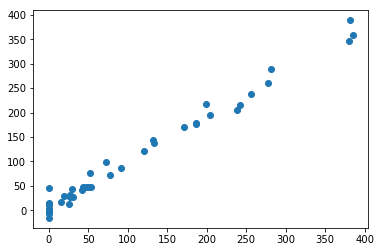

In [84]:
plt.scatter(y3_test, lm2predictions)

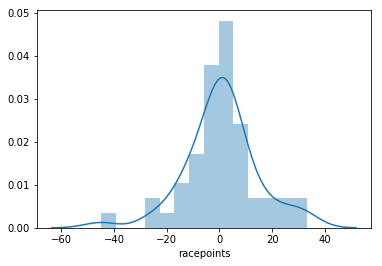

In [85]:
sns.distplot((y3_test - lm2predictions))

Calculate accuracy

In [86]:
sk.metrics.mean_absolute_error(y3_test, lm2predictions)

9.4286519457441056

>This shows that we are off by an average of nearly 9.5 points per driver, more than double the amount that we were off by in the original model using the older data.

Calculate the average points earned per driver over the 2011-2017 seasons

In [87]:
driverseasonnew.racepoints.mean()

81.508771929824562

However the average number of points per season per driver has increased by nearly 10x since 2011!

Note the dramatic increase in total racepoints from 2001-2011 in the graph below.

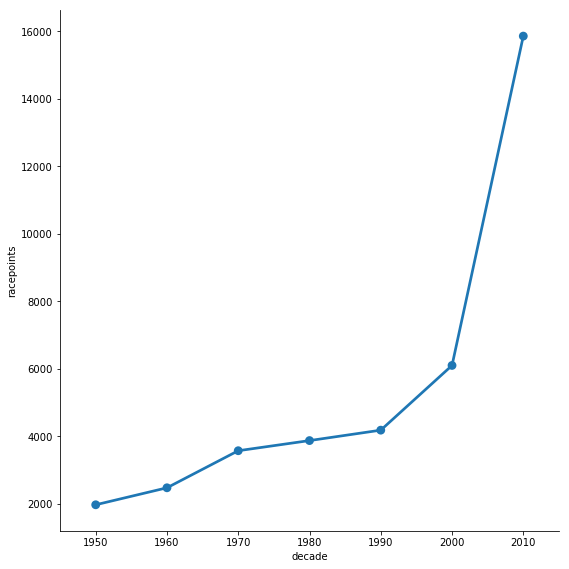

In [88]:
df['decade'] = df.year//10*10
decadepoints = df.groupby('decade',as_index=False).racepoints.sum()
sns.factorplot(x='decade',y='racepoints',data=decadepoints, size=8)

**Conclusion (Second Model): Though the difference in the predicted vs actual values for points is higher when looking at the newer data (2011-2017) than the older data (1950-2010), the newer model is actually better because we're only off by only 12% from the average points earned, compared with nearly 28% from the original model. This indicates that adding in pit stop data provides greater accuracy in the predictive power of the model.**

**When looking across both models, the key takeaway here is that regardless of how adept the individual driver is at maneuvering the course, there is quite possibly even more importance on the technical team and pit crew to ensure that the vehicle is in optimal racing condition.**

### Question 3: Can we predict who will win the 2018 races?

Note the number of constructor wins in the graph below. Contrary to initial expectations, the prediction results for 2018 (shown in the model below), are not consistent with the graph, indicating a possible shift in recent constructor successes.

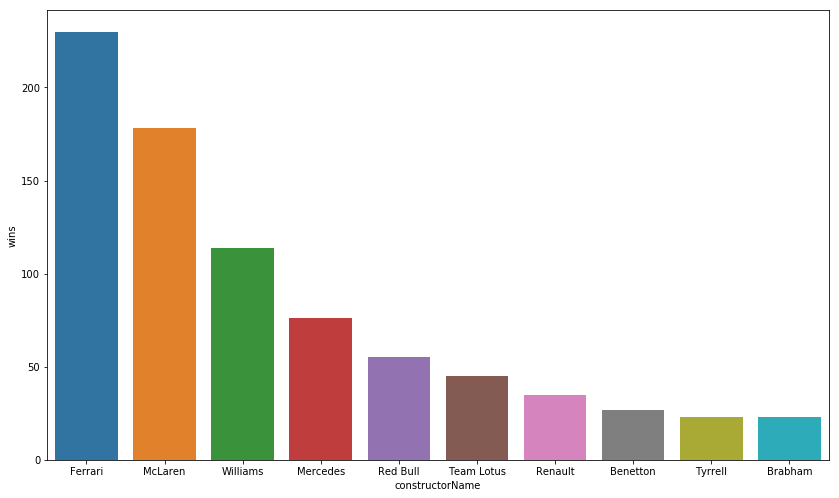

In [89]:
dfcons = df.merge(constructors, how='left', left_on='constructorId', right_on='constructorId')
set_wins_max = dfcons.groupby('constructorName',as_index=False).sum().sort_values(by='wins', ascending = False).head(10)
ax_dims = (14, 8.27)
f, ax = plt.subplots(figsize=ax_dims)
sns.barplot(x='constructorName',y='wins',data=set_wins_max)

In [90]:
resultsnew = df.drop(['raceId', 'constructorId', 'grid', 'positionOrder', 'racepoints', 'lapsfinished',
                      'constructorName','birthyear', 'laps', 'lapsfinishedpct', 'top10', 'lapsleadingpct',
                     'lapstop3pct', 'lapstop5pct', 'lapstop10pct', '10pctpos', '25pctpos', '50pctpos','StatusNew',
                     'region', 'constructorRegion', 'driverRegion'], axis=1)

Identify the drivers in 2017 that we assume will also race in 2018

In [91]:
resultsnew.head(3)

,driverId,year,round,constructorRef,driverRef,qualifyingposition,drivercountrymatch,constcountrymatch,driverage,wins,pitstopduration,pitstop,lapsleading,decade
0,1,2008,1,mclaren,hamilton,1.0,0.0,0.0,23.0,1.0,0.0,0.0,50.0,2000
1,2,2008,1,bmw_sauber,heidfeld,5.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,2000
2,3,2008,1,williams,rosberg,7.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,2000


In [92]:
unique_drivers = resultsnew[resultsnew.year == 2017]['driverId'].unique().tolist()
regress = resultsnew[resultsnew['driverId'].isin(unique_drivers)]

Chop down the years so we have the pit stop data

In [93]:
regress = regress[regress.year.isin([2011, 2012, 2013, 2014, 2015, 2016, 2017])]

Drop unwanted columns and get dummies for categorical variables

In [94]:
logistic = regress.drop(['driverId', 'year'], axis=1)
logistic = pd.get_dummies(logistic)

In [95]:
logistic.head(3)

,round,qualifyingposition,drivercountrymatch,constcountrymatch,driverage,wins,pitstopduration,pitstop,lapsleading,decade,constructorRef_caterham,constructorRef_ferrari,constructorRef_force_india,constructorRef_haas,constructorRef_hrt,constructorRef_lotus_f1,constructorRef_manor,constructorRef_mclaren,constructorRef_mercedes,constructorRef_red_bull,constructorRef_renault,constructorRef_sauber,constructorRef_toro_rosso,constructorRef_williams,driverRef_alonso,driverRef_bottas,driverRef_brendon_hartley,driverRef_button,driverRef_ericsson,driverRef_gasly,driverRef_giovinazzi,driverRef_grosjean,driverRef_hamilton,driverRef_hulkenberg,driverRef_jolyon_palmer,driverRef_kevin_magnussen,driverRef_kvyat,driverRef_massa,driverRef_max_verstappen,driverRef_ocon,driverRef_perez,driverRef_raikkonen,driverRef_resta,driverRef_ricciardo,driverRef_sainz,driverRef_stroll,driverRef_vandoorne,driverRef_vettel,driverRef_wehrlein
20776,1,1.0,0.0,0.0,24.0,1.0,23.3195,2.0,55.0,2010,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
20777,1,2.0,0.0,0.0,26.0,0.0,23.2130,2.0,3.0,2010,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20779,1,5.0,0.0,0.0,30.0,0.0,24.0550,3.0,0.0,2010,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [96]:
X18 = logistic.drop('wins', axis=1)
y18 = logistic['wins']

In [97]:
logmodel = LogisticRegression()

Fit model

In [98]:
result = logmodel.fit(X18, y18)

Get predicted values

In [99]:
predictions = logmodel.predict(X18)
predictions

array([ 1.,  0.,  0., ...,  0.,  0.,  0.])

Classification report and confusion matrix

In [100]:
print(sk.metrics.classification_report(y18, predictions))

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99      1813
        1.0       0.90      0.86      0.88       110

avg / total       0.99      0.99      0.99      1923



Confusion Matrix

In [101]:
sk.metrics.confusion_matrix(y18, predictions)

array([[1802,   11],
       [  15,   95]], dtype=int64)

Select the coefficients but change the coefficient of round to 0

In [102]:
coef = result.coef_
coef2 = [0, -8.63489634e-02, -1.01004931e-05,
         1.06420222e-01,  1.79429937e-01,  6.79818669e-01,
        -1.61663692e-01, -1.43857834e-01, -1.48962834e-02,
        -1.93651897e-02, -4.63581956e-01, -6.21584577e-02,
        -5.08667284e-02,  3.57284254e-01, -6.65640087e-02,
         4.36014002e-01,  5.92660623e-01, -3.10563582e-02,
        -1.28366050e-01, -2.58034572e-01, -6.27324035e-01,
        -3.11702520e-01,  3.31588098e-01, -2.92216317e-01,
        -4.93367700e-03,  1.09982924e+00, -8.97690327e-02,
        -8.61626818e-03, -5.56160191e-03, -5.41563481e-01,
         4.50165432e-01, -3.49100482e-01, -5.84734866e-02,
        -2.20838432e-01, -2.64155526e-01, -1.70722881e-01,
        -1.08008045e-01, -6.83046104e-02, -2.57202704e-01,
         4.75685527e-01, -6.55418915e-02,  4.07431588e-01,
        -1.45716834e-01, -6.58181461e-02, -8.15104795e-02,
        -5.38771085e-01, -7.58321793e-02, -4.93743732e-01,
         4.02497911e-01, -2.92555933e-01, -2.64155526e-01,
        -4.22227040e-02, -3.72652512e-03,  2.89915437e-01,
        -9.74701370e-02, -7.20982806e-01, -7.34705445e-02,
        -6.21584577e-02, -4.78478240e-01, -5.64538539e-02,
        -5.08667284e-02]

Import data set that has the limited 2018 information, with the rest of the columns filled in with historical averages

In [103]:
logit2 = pd.read_csv('logit_test2.csv')

logit2.drop(['Unnamed: 0'],axis=1, inplace = True)

Multiply by each value by the corresponding coefficient from the test set

In [104]:
logit2['score'] = logit2.multiply(coef2).sum(axis = 1)

Find the indices of the maximum likelihood winner for each round

In [105]:
idx = logit2.groupby('round').apply(lambda x: x['score'].argmax())

winners = logit2.loc[idx]

Find the winners

In [106]:
win_list = winners.sum()

empty_col = win_list[win_list == 0].index.tolist()

winners_reduced = winners.drop(empty_col, axis=1)

merge_round = winners_reduced['round'].to_frame()

display = winners_reduced.loc[:,'constructorRef_ferrari':'driverRef_wehrlein']

display = display.merge(merge_round, how = 'left', left_index = True, right_index = True).reset_index()

display.drop('index', axis=1, inplace = True)

display = display.set_index('round')
display

,constructorRef_ferrari,constructorRef_manor,constructorRef_williams,driverRef_alonso,driverRef_ocon,driverRef_stroll,driverRef_wehrlein
round,,,,,,,
1,0,1,0,0,0,0,1
2,0,0,1,0,0,1,0
3,1,0,0,1,0,0,0
4,0,0,1,0,0,1,0
5,0,1,0,0,1,0,0
6,0,1,0,0,1,0,0
7,0,1,0,0,1,0,0
8,0,1,0,0,1,0,0
9,0,1,0,0,1,0,0


**Conclusion: We find that the most likely winner for the first round is Wehrlein driving for Manor. Despite Ferrari historically winning the most races they will only win 4 races in 2018.  Additionally, we find that if each driver and team perform at their 2011-2017 average, and given the 2018 race information, Manor will be the team with the most wins, with 14(!), with the other 3 coming from Williams. **